In [466]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Exercise 3

### Question A

In [503]:
x = np.array([[0, 0],
              [0, 1],
              [1, 0],
              [1, 1]])

y = np.array([[0],
              [1],
              [1],
              [0]])

In [504]:
df = pd.DataFrame(np.concatenate((x, y), axis=1), columns=('x1', 'x2', 'y'))
df.style.hide()

x1,x2,y
0,0,0
0,1,1
1,0,1
1,1,0


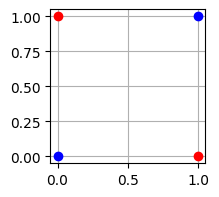

In [505]:
plt.figure(figsize=(2,2))

plt.plot(*x[0], 'o', color='blue')
plt.plot(*x[1], 'o', color='red')
plt.plot(*x[2], 'o', color='red')
plt.plot(*x[3], 'o', color='blue')
plt.grid()

plt.show()

In [506]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        # Initialize number of nodes of input, hidden, and output layer
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # Initialize weights (w) and biases (b) 
        # input -> hidden
        self.w1 = np.random.rand(self.input_size, self.hidden_size)
        self.b1 = np.zeros((1, self.hidden_size))

        # hidden -> output
        self.w2 = np.random.rand(self.hidden_size, self.output_size)
        self.b2 = np.zeros((1, self.output_size))

    def sigmoid(self, x, deriv=False):
        """Sigmoid activation function"""
        if deriv:
            return self.sigmoid(x) * (1 - self.sigmoid(x))
        return 1 / (1 + np.exp(-x))

    def reLU(self, x):
        """reLU activation function"""
        return np.maximum(0, x)

    def feedforward(self, x):
        """Feedforward"""
        # input -> hidden
        self.z1 = np.dot(x, self.w1) + self.b1
        self.a1 = self.sigmoid(self.z1)

        # hidden -> output
        self.z2 = np.dot(self.a1, self.w2) + self.b2
        self.a2 = self.sigmoid(self.z2)

        return self.a2

    def backpropagation(self, x, y, learning_rate):
        """Backpropagation"""
        self.m = y.size

        self.d_z2 = self.a2 - y
        self.d_w2 = np.dot(self.a1.T, self.d_z2) / self.m
        self.d_b2 = np.sum(self.d_z2) / self.m
        
        self.d_z1 = np.dot(self.d_z2, self.w2.T) * self.sigmoid(self.z1, deriv=True)
        self.d_w1 = np.dot(x.T, self.d_z1) / self.m
        self.d_b1 = np.sum(self.d_z1) / self.m

        self.w1 -= self.d_w1 * learning_rate
        self.b1 -= self.d_b1 * learning_rate
        self.w2 -= self.d_w2 * learning_rate
        self.b2 -= self.d_b2 * learning_rate

    def train(self, x, y, learning_rate, epochs):
        """Optimize weight and bias parameters"""
        for epoch in range(epochs):
            self.feedforward(x)
            self.backpropagation(x, y, learning_rate)

            if not epoch % (epochs / 10):
                print(f'Epoch {epoch}: {np.mean(np.square(y - self.a2))}')

    def predict(self, x):
        """Get feedforward result with current parameters"""
        return self.feedforward(x)

In [507]:
learning_rate = 0.1
epochs = 10000
nn_A = NeuralNetwork(2, 2, 1)
nn_A.train(x, y, learning_rate, epochs)
nn_A.predict(x)

Epoch 0: 0.28750713953478074
Epoch 1000: 0.24711894247306262
Epoch 2000: 0.22778610046574282
Epoch 3000: 0.16724347322448313
Epoch 4000: 0.06165726917966337
Epoch 5000: 0.012312515313039289
Epoch 6000: 0.003917683487172077
Epoch 7000: 0.0017692009721991015
Epoch 8000: 0.000974382603577831
Epoch 9000: 0.0006066845628134073


array([[0.02135573],
       [0.98146364],
       [0.98146085],
       [0.02229757]])

### Question B

Load raw data

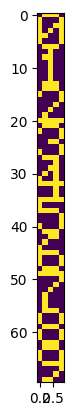

In [508]:
data = np.loadtxt("TP3-ej3-digitos.txt", dtype=np.uint8) 
plt.imshow(data);

Flatten data

In [509]:
data_flattened = data.flatten()
data_flattened = np.reshape(data_flattened, (10, 35))

print(data_flattened.shape)
data_flattened

(10, 35)


array([[0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,
        0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0],
       [0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0],
       [0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0],
       [0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1,
        1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
       [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0],
       [0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0,
        0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 1, 1, 1, 0, 1

Initialize x input (flattened digit) and y output (result of whether digit is pair)

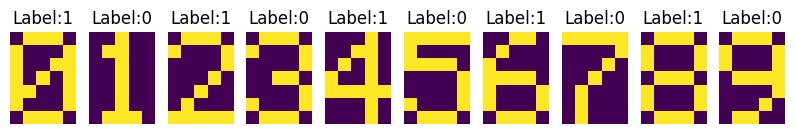

In [510]:
x = data_flattened
y = np.array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0])

plt.figure(figsize=(10, 3))
for i, img in enumerate(data_flattened):
    plt.subplot(1, 10, i+1)
    plt.title('Label:' + str(y[i]))
    plt.axis('off')
    plt.imshow(np.reshape(img, (7,5)))

In [511]:
input_size = 35
hidden_size = 10
output_size = 1

In [512]:
learning_rate = 0.1
epochs = 10000
nn_B = NeuralNetwork(input_size, hidden_size, output_size)
nn_B.train(x, y, learning_rate, epochs)
nn_B.predict(x)

ValueError: shapes (10,10) and (1,10) not aligned: 10 (dim 1) != 1 (dim 0)